# **IMPORTS & DATA PREPROCESSING**




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import pickle
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score,
    precision_score, recall_score, f1_score, accuracy_score,
    precision_recall_curve
)
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import io


In [3]:
# Load and prepare data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train, y_test = y_train.flatten(), y_test.flatten()

# Binary classification (vehicles vs animals)
vehicle_labels = [0, 1, 8, 9]
y_train = np.isin(y_train, vehicle_labels).astype(np.float32)
y_test = np.isin(y_test, vehicle_labels).astype(np.float32)

# Normalize and flatten
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


# **MODEL:01**
low accuracy

In [ ]:
# Step 4: Split training data into train + validation
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_flat, y_train, test_size=0.3, random_state=42, stratify=y_train
)

# Step 5: Build ANN model
model1 = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_flat.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Step 6: Compile the model
model1.compile(optimizer=Adam(learning_rate=0.001),
               loss='binary_crossentropy',
               metrics=['accuracy'])

# Step 7: Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Step 8: Train the model
history1 = model1.fit(
    X_train_final, y_train_final,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=2
)

# Step 9: Evaluate on test data
test_loss, test_acc = model1.evaluate(X_test_flat, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

# Step 10: Save model and history
save_path = '/content/drive/MyDrive/cifar_models/model1'
os.makedirs(save_path, exist_ok=True)

model1.save(f'{save_path}/model1_no_pca.h5')

with open(f'{save_path}/history1_no_pca.pkl', 'wb') as f:
    pickle.dump(history1.history, f)

print("Model and training history saved successfully to Google Drive.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
547/547 - 19s - 35ms/step - accuracy: 0.7877 - loss: 0.4768 - val_accuracy: 0.7879 - val_loss: 0.4602
Epoch 2/50
547/547 - 17s - 32ms/step - accuracy: 0.8237 - loss: 0.4044 - val_accuracy: 0.8310 - val_loss: 0.3916
Epoch 3/50
547/547 - 15s - 27ms/step - accuracy: 0.8394 - loss: 0.3777 - val_accuracy: 0.8243 - val_loss: 0.3942
Epoch 4/50
547/547 - 21s - 38ms/step - accuracy: 0.8454 - loss: 0.3645 - val_accuracy: 0.8445 - val_loss: 0.3606
Epoch 5/50
547/547 - 21s - 38ms/step - accuracy: 0.8505 - loss: 0.3528 - val_accuracy: 0.8165 - val_loss: 0.4234
Epoch 6/50
547/547 - 15s - 27ms/step - accuracy: 0.8574 - loss: 0.3405 - val_accuracy: 0.8557 - val_loss: 0.3458
Epoch 7/50
547/547 - 14s - 25ms/step - accuracy: 0.8626 - loss: 0.3287 - val_accuracy: 0.8537 - val_loss: 0.3510
Epoch 8/50
547/547 - 15s - 27ms/step - accuracy: 0.8634 - loss: 0.3301 - val_accuracy: 0.8477 - val_loss: 0.3583
Epoch 9/50
547/547 - 20s - 37ms/step - accuracy: 0.8695 - loss: 0.3194 - val_accuracy: 0.8448 - 


Test Accuracy: 85.91%
Model and training history saved successfully to Google Drive.


# **MODEL:02**

lacks regularization (risk of overfitting).


In [ ]:
# Step 5: Apply PCA (keep 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

print(f"PCA reduced input size from {X_train_flat.shape[1]} to {X_train_pca.shape[1]} features.")

# Split training data into train + validation with stratify on labels
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_pca, y_train, test_size=0.3, random_state=42, stratify=y_train
)

# Step 6: Build ANN model with Batch Normalization
model2 = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Output for binary classification
])

# Step 7: Compile the model
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Optional: Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Step 8: Train the model with explicit validation data
history1 = model2.fit(
    X_train_final, y_train_final,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),  # Use validation set instead of validation_split
    callbacks=[early_stop],
    verbose=2
)

# Step 9: Evaluate on test data
test_loss, test_acc = model2.evaluate(X_test_pca, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

# Step 10: Save the Model, PCA, and Training History
save_path = '/content/drive/MyDrive/cifar_models/model2'
os.makedirs(save_path, exist_ok=True)

# Save the model
model2.save(f'{save_path}/model2.h5')

# Save the PCA transformer
joblib.dump(pca, f'{save_path}/pca_transformer.pkl')

# Save the training history
with open(f'{save_path}/history2.pkl', 'wb') as f:
    pickle.dump(history1.history, f)

print("Model, PCA, and history saved successfully to Google Drive.")


PCA reduced input size from 3072 to 217 features.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


547/547 - 4s - 7ms/step - accuracy: 0.8497 - loss: 0.3580 - val_accuracy: 0.8710 - val_loss: 0.3172
Epoch 2/50
547/547 - 4s - 7ms/step - accuracy: 0.8975 - loss: 0.2574 - val_accuracy: 0.8795 - val_loss: 0.2917
Epoch 3/50
547/547 - 3s - 5ms/step - accuracy: 0.9213 - loss: 0.1997 - val_accuracy: 0.8846 - val_loss: 0.2935
Epoch 4/50
547/547 - 3s - 5ms/step - accuracy: 0.9401 - loss: 0.1535 - val_accuracy: 0.8863 - val_loss: 0.3115
Epoch 5/50
547/547 - 6s - 11ms/step - accuracy: 0.9591 - loss: 0.1112 - val_accuracy: 0.8859 - val_loss: 0.3272



Test Accuracy: 88.60%
Model, PCA, and history saved successfully to Google Drive.


# **MODEL:03**
using StandardScaler, explicit validation split, and progressive dropout
# **FINAL MODEL**

In [ ]:
# 4. Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# 5. Apply PCA with 95% variance retention (automatic number of components)
global pca_95
pca_95 = PCA(n_components=0.95, random_state=42)
X_train_pca = pca_95.fit_transform(X_train_scaled)
X_test_pca = pca_95.transform(X_test_scaled)
print(f"Selected components for 95% variance: {pca_95.n_components_}")

print(f"Saved PCA components: {pca_95.n_components_}")  # Should be 221
# 6. Train/test split (optional if you want to keep validation separate)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_pca, y_train, test_size=0.2, random_state=42,stratify=y_train
)

# 7. Build ANN model
model3 = Sequential([
    Dense(512, activation='relu', input_shape=(pca_95.n_components_,)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # binary classification
])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 8. Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history3 = model3.fit(
    X_train_final, y_train_final,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=2
)

# 9. Evaluate on test set
test_loss, test_acc = model3.evaluate(X_test_pca, y_test, verbose=0)
print(f" Test Accuracy: {test_acc * 100:.2f}%")

# Step 10: Save model, PCA, and training history
save_path = '/content/drive/MyDrive/cifar_models/model3'
os.makedirs(save_path, exist_ok=True)

# Save the model
model3.save(f'{save_path}/model3.h5')

# Save the PCA transformer
joblib.dump(pca_95, f'{save_path}/pca_transformer3.pkl')

# Save the training history
with open(f'{save_path}/history3.pkl', 'wb') as f:
    pickle.dump(history3.history, f)

print(" Model3, PCA3, and history3 saved successfully to Google Drive.")

Selected components for 95% variance: 221
Saved PCA components: 221
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 - 9s - 15ms/step - accuracy: 0.8205 - loss: 0.4154 - val_accuracy: 0.8715 - val_loss: 0.3140
Epoch 2/50
625/625 - 12s - 19ms/step - accuracy: 0.8631 - loss: 0.3264 - val_accuracy: 0.8814 - val_loss: 0.2847
Epoch 3/50
625/625 - 7s - 12ms/step - accuracy: 0.8772 - loss: 0.2933 - val_accuracy: 0.8898 - val_loss: 0.2717
Epoch 4/50
625/625 - 6s - 9ms/step - accuracy: 0.8861 - loss: 0.2735 - val_accuracy: 0.8929 - val_loss: 0.2626
Epoch 5/50
625/625 - 10s - 16ms/step - accuracy: 0.8983 - loss: 0.2501 - val_accuracy: 0.8951 - val_loss: 0.2597
Epoch 6/50
625/625 - 5s - 9ms/step - accuracy: 0.9032 - loss: 0.2352 - val_accuracy: 0.8979 - val_loss: 0.2582
Epoch 7/50
625/625 - 11s - 17ms/step - accuracy: 0.9102 - loss: 0.2230 - val_accuracy: 0.9008 - val_loss: 0.2500
Epoch 8/50
625/625 - 5s - 8ms/step - accuracy: 0.9147 - loss: 0.2087 - val_accuracy: 0.9025 - val_loss: 0.2496
Epoch 9/50
625/625 - 6s - 10ms/step - accuracy: 0.9200 - loss: 0.1984 - val_accuracy: 0.9047 - val_loss: 0.2544
Epo

 Test Accuracy: 89.89%
 Model3, PCA3, and history3 saved successfully to Google Drive.


# **LOADING ALL MODELS**

In [10]:
#MODEL 1
# Load the model
model1 = load_model('/content/drive/MyDrive/cifar_models/model1/model1_no_pca.h5')

# Load training history
with open('/content/drive/MyDrive/cifar_models/model1/history1_no_pca.pkl', 'rb') as f:
    history1 = pickle.load(f)

# Step 6: Evaluate
# Final evaluation should use the same shape as training input
test_loss, test_acc = model1.evaluate(X_test_flat, y_test, verbose=0)
print(f"\n Loaded model accuracy: {test_acc * 100:.2f}%")



 Loaded model accuracy: 86.44%


 Final Training Accuracy: 87.03%
 Final Validation Accuracy: 85.77%
 Test Accuracy: 86.44%


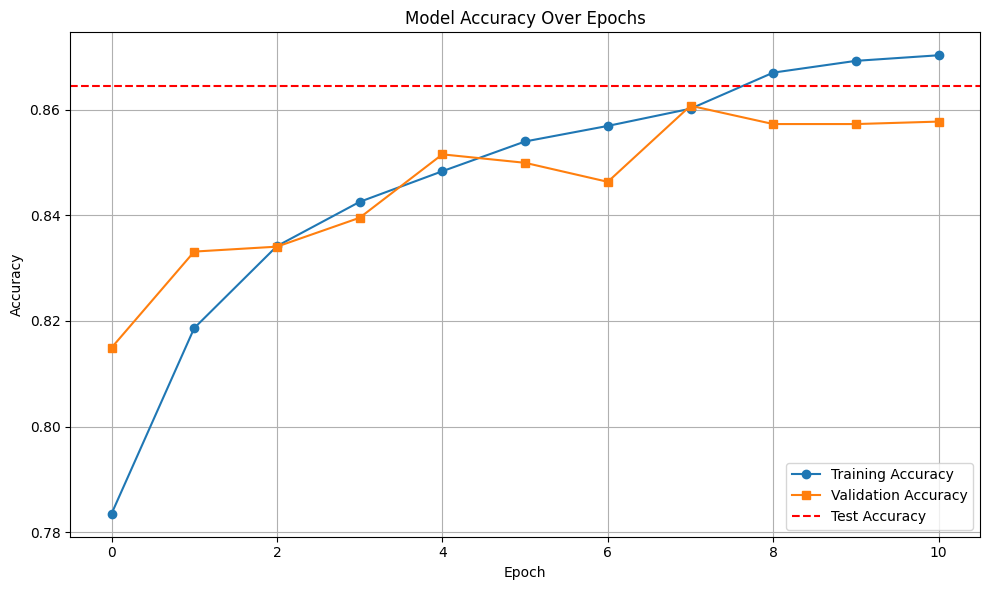

In [11]:
# 10. Print train and validation accuracies
final_train_acc = history1['accuracy'][-1]
final_val_acc = history1['val_accuracy'][-1]
print(f" Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f" Final Validation Accuracy: {final_val_acc * 100:.2f}%")
print(f" Test Accuracy: {test_acc * 100:.2f}%")

# 11. Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history1['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history1['val_accuracy'], label='Validation Accuracy', marker='s')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# Load model2
model2 = load_model('/content/drive/MyDrive/cifar_models/model2/model2.h5')

# Load PCA
pca = joblib.load('/content/drive/MyDrive/cifar_models/model2/pca_transformer2.pkl')
X_test_pca = pca.transform(X_test_flat)
# Load training history
with open('/content/drive/MyDrive/cifar_models/model2/history2.pkl', 'rb') as f:
    history2 = pickle.load(f)
# Step 6: Evaluate
test_loss, test_acc = model2.evaluate(X_test_pca, y_test, verbose=0)
print(f"\n Loaded model accuracy: {test_acc * 100:.2f}%")


 Loaded model accuracy: 89.14%


 Final Training Accuracy: 96.84%
 Final Validation Accuracy: 89.15%
 Test Accuracy: 89.14%


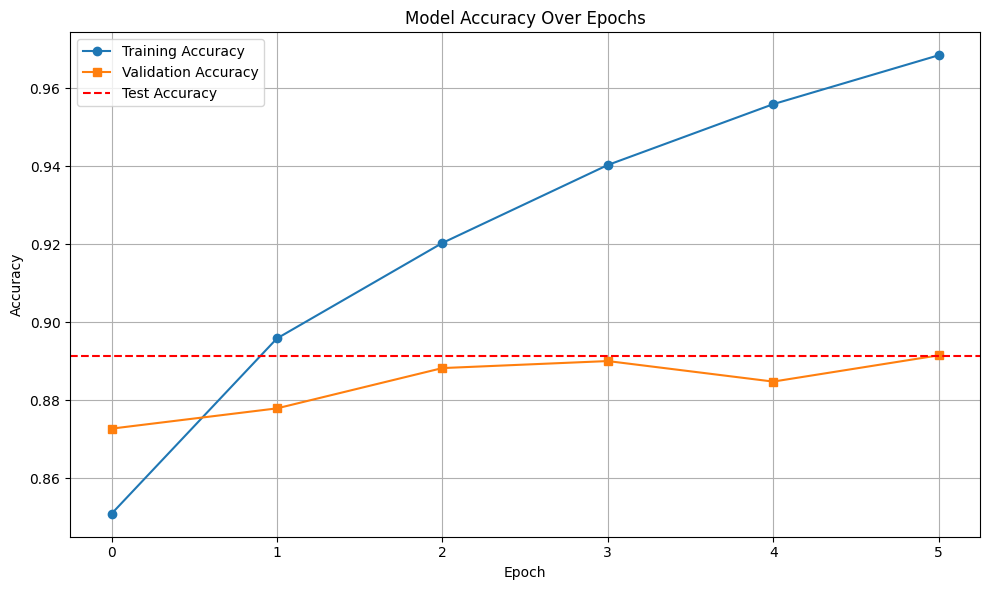

In [13]:
# 10. Print train and validation accuracies
final_train_acc = history2['accuracy'][-1]
final_val_acc = history2['val_accuracy'][-1]
print(f" Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f" Final Validation Accuracy: {final_val_acc * 100:.2f}%")
print(f" Test Accuracy: {test_acc * 100:.2f}%")

# 11. Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history2['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history2['val_accuracy'], label='Validation Accuracy', marker='s')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# Load scaler and PCA (do NOT refit)
scaler = joblib.load('/content/drive/MyDrive/cifar_models/model3/scaler.pkl')
pca_95 = joblib.load('/content/drive/MyDrive/cifar_models/model3/pca_transformer3.pkl')

# Load model
model3 = load_model('/content/drive/MyDrive/cifar_models/model3/model3.h5')

# Preprocess test data exactly like during training
X_test_flat = X_test.reshape((len(X_test), -1))
X_test_scaled = scaler.transform(X_test_flat)
X_test_pca = pca_95.transform(X_test_scaled)
with open('/content/drive/MyDrive/cifar_models/model3/history3.pkl', 'rb') as f:
    history3 = pickle.load(f)
# Evaluate loaded model
test_loss, test_acc = model3.evaluate(X_test_pca, y_test, verbose=0)
print(f" Loaded model accuracy: {test_acc * 100:.2f}%")


 Loaded model accuracy: 90.30%


 Final Training Accuracy: 93.92%
 Final Validation Accuracy: 89.84%
 Test Accuracy: 90.30%


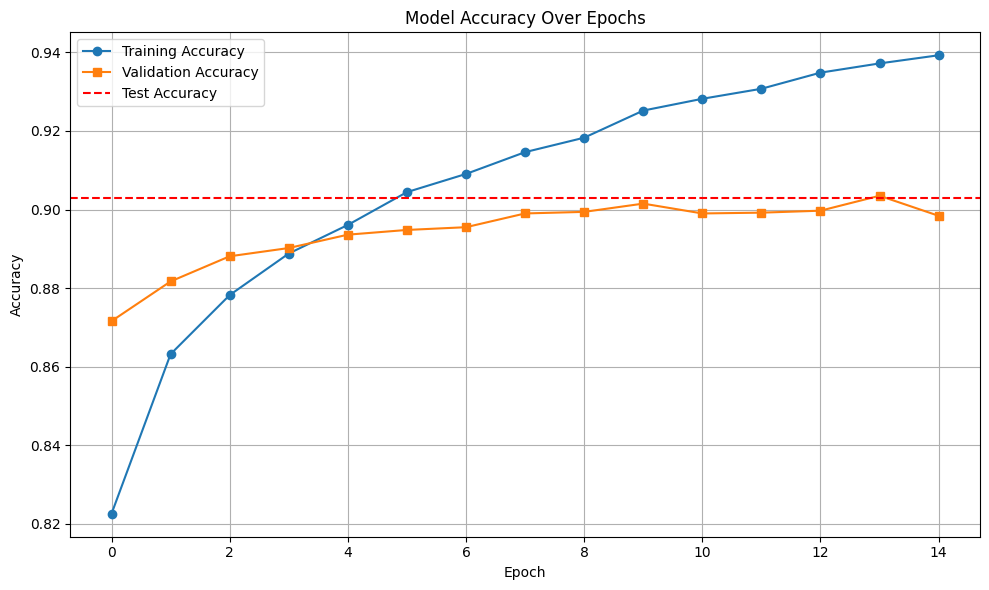

In [15]:
# 10. Print train and validation accuracies
final_train_acc = history3['accuracy'][-1]
final_val_acc = history3['val_accuracy'][-1]
print(f" Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f" Final Validation Accuracy: {final_val_acc * 100:.2f}%")
print(f" Test Accuracy: {test_acc * 100:.2f}%")

# 11. Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history3['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history3['val_accuracy'], label='Validation Accuracy', marker='s')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **MODEL:01 (PERFORMANCE)**





313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

 Confusion Matrix:
[[5343  657]
 [ 699 3301]]


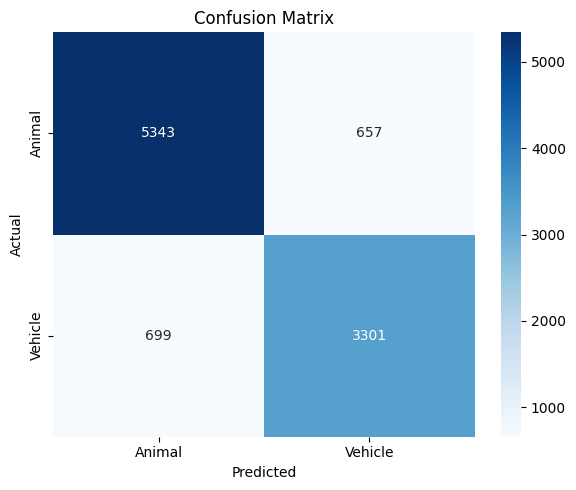


 Classification Report:
              precision    recall  f1-score   support

      Animal       0.88      0.89      0.89      6000
     Vehicle       0.83      0.83      0.83      4000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

 Accuracy     : 0.8644
 Precision    : 0.8340
 Recall       : 0.8253
 Macro F1     : 0.8585
 ROC AUC Score: 0.9285


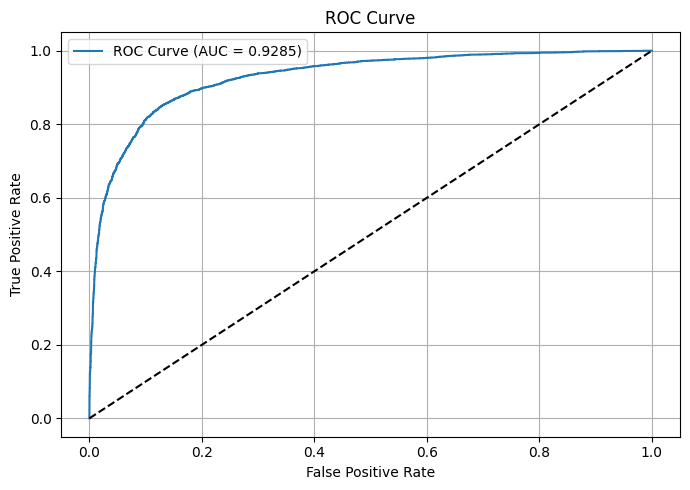

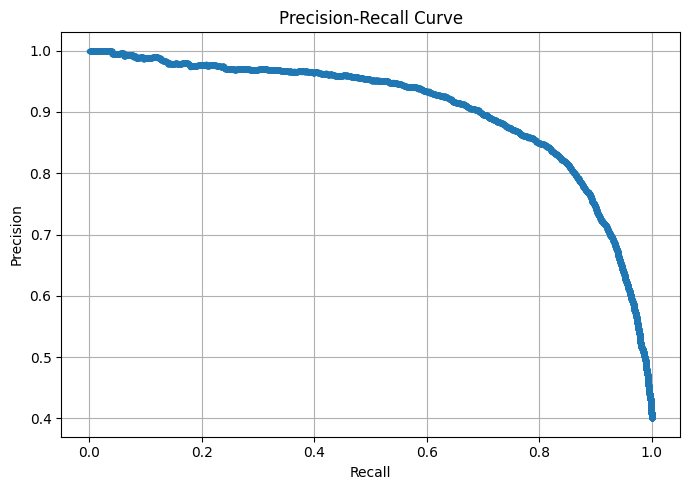

In [16]:
# === Load model trained on flattened input ===
model1 = load_model('/content/drive/MyDrive/cifar_models/model1/model1_no_pca.h5')

# === Use flattened test data directly (no PCA) ===
# Make sure X_test_flat is already defined
y_probs = model1.predict(X_test_flat).ravel()                  # Probability scores
y_pred = (y_probs > 0.5).astype(int)                          # Binary predictions

# === 1. Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("\n Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Animal', 'Vehicle'],
            yticklabels=['Animal', 'Vehicle'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === 2. Classification Report ===
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Animal', 'Vehicle']))

# === 3. Evaluation Metrics ===
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, y_probs)

print(f" Accuracy     : {accuracy:.4f}")
print(f" Precision    : {precision:.4f}")
print(f" Recall       : {recall:.4f}")
print(f" Macro F1     : {macro_f1:.4f}")
print(f" ROC AUC Score: {roc_auc:.4f}")

# === 4. ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 5. Precision-Recall Curve ===
prec, rec, _ = precision_recall_curve(y_test, y_probs)
plt.figure(figsize=(7, 5))
plt.plot(rec, prec, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.tight_layout()
plt.show()


# **MODEL:02 (PERFORMANCE)**


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

 Confusion Matrix:
[[5555  445]
 [ 641 3359]]


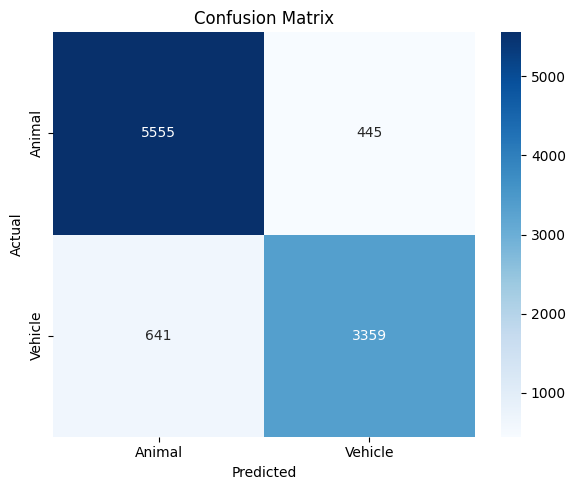


 Classification Report:
              precision    recall  f1-score   support

      Animal       0.90      0.93      0.91      6000
     Vehicle       0.88      0.84      0.86      4000

    accuracy                           0.89     10000
   macro avg       0.89      0.88      0.89     10000
weighted avg       0.89      0.89      0.89     10000

 Accuracy     : 0.8914
 Precision    : 0.8830
 Recall       : 0.8397
 Macro F1     : 0.8859
 ROC AUC Score: 0.9516


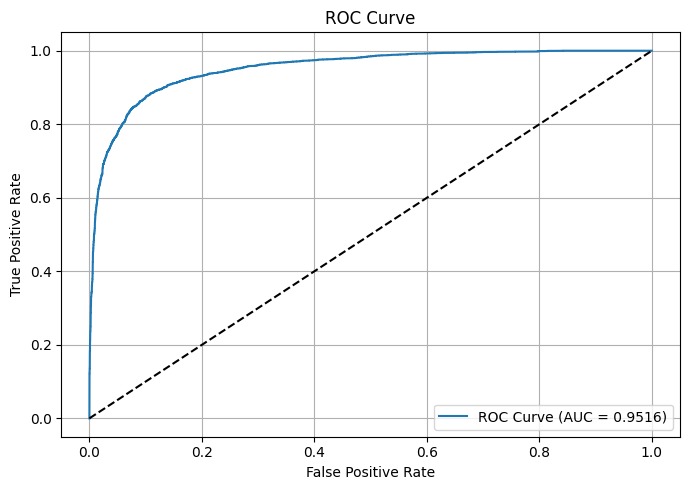

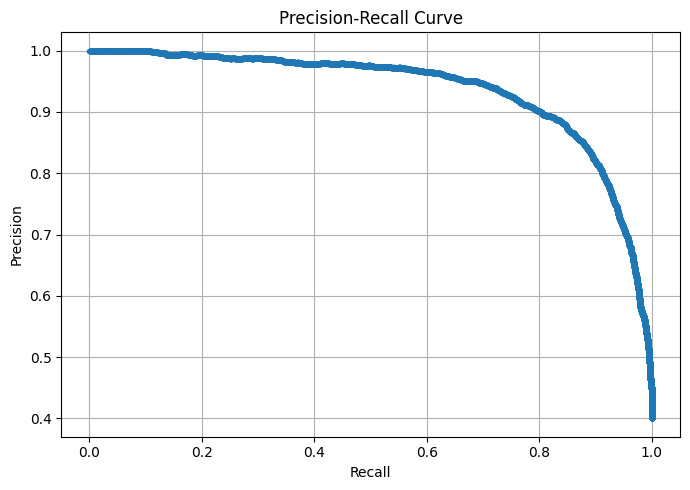

In [17]:
# === Load PCA and transform test data ===
pca = joblib.load('/content/drive/MyDrive/cifar_models/model2/pca_transformer2.pkl')
X_test_pca = pca.transform(X_test_flat)

# === Predict with model2 ===
y_probs = model2.predict(X_test_pca).ravel()                  # Probability scores
y_pred = (y_probs > 0.5).astype(int)                          # Binary predictions

# === 1. Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("\n Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Animal', 'Vehicle'],
            yticklabels=['Animal', 'Vehicle'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === 2. Classification Report ===
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Animal', 'Vehicle']))

# === 3. Evaluation Metrics ===
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, y_probs)

print(f" Accuracy     : {accuracy:.4f}")
print(f" Precision    : {precision:.4f}")
print(f" Recall       : {recall:.4f}")
print(f" Macro F1     : {macro_f1:.4f}")
print(f" ROC AUC Score: {roc_auc:.4f}")

# === 4. ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 5. Precision-Recall Curve ===
prec, rec, _ = precision_recall_curve(y_test, y_probs)
plt.figure(figsize=(7, 5))
plt.plot(rec, prec, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.tight_layout()
plt.show()


# **MODEL:03 (PERFORMANCE)**


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

 Confusion Matrix:
[[5541  459]
 [ 511 3489]]


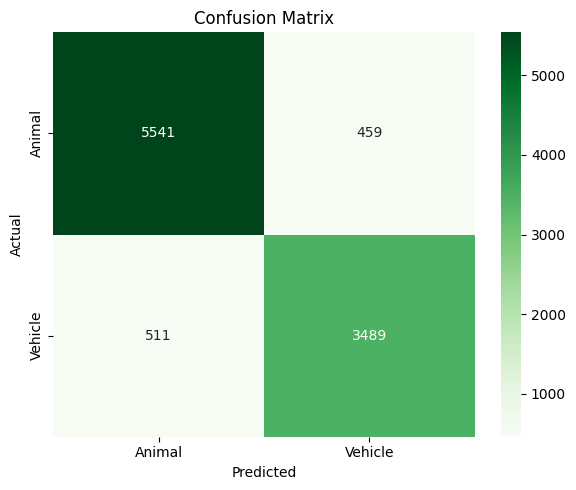


 Classification Report:
              precision    recall  f1-score   support

      Animal       0.92      0.92      0.92      6000
     Vehicle       0.88      0.87      0.88      4000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

 Accuracy     : 0.9030
 Precision    : 0.8837
 Recall       : 0.8722
 Macro F1     : 0.8987
 ROC AUC Score: 0.9618


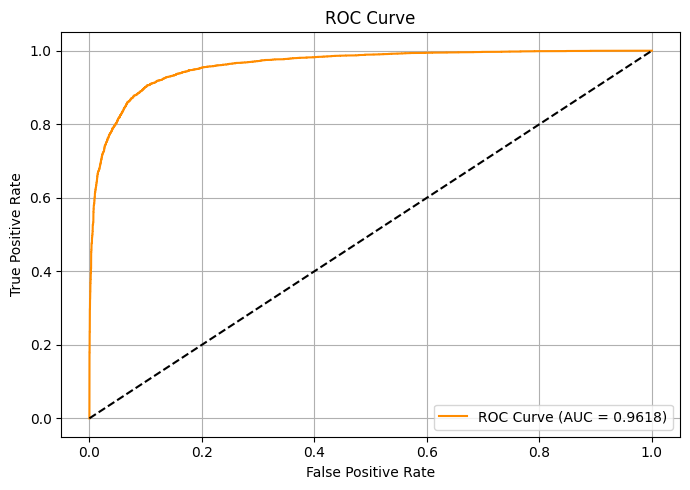

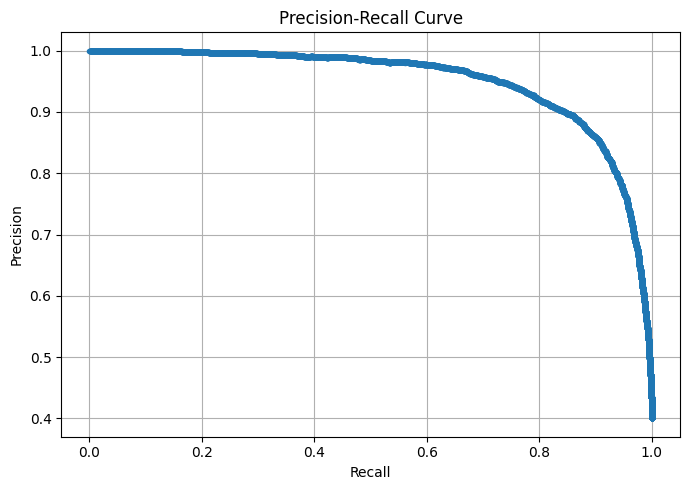

In [18]:
# === Load pre-trained components ===
scaler = joblib.load('/content/drive/MyDrive/cifar_models/model3/scaler.pkl')
pca_95 = joblib.load('/content/drive/MyDrive/cifar_models/model3/pca_transformer3.pkl')
model3 = load_model('/content/drive/MyDrive/cifar_models/model3/model3.h5')

# === Preprocess Test Data ===
X_test_flat = X_test.reshape((len(X_test), -1))
X_test_scaled = scaler.transform(X_test_flat)
X_test_pca = pca_95.transform(X_test_scaled)

# === Predict using the loaded model ===
y_probs = model3.predict(X_test_pca).ravel()
y_pred = (y_probs > 0.5).astype(int)

# === 1. Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("\n Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Animal', 'Vehicle'],
            yticklabels=['Animal', 'Vehicle'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === 2. Classification Report ===
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Animal', 'Vehicle']))

# === 3. Evaluation Metrics ===
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, y_probs)

print(f" Accuracy     : {accuracy:.4f}")
print(f" Precision    : {precision:.4f}")
print(f" Recall       : {recall:.4f}")
print(f" Macro F1     : {macro_f1:.4f}")
print(f" ROC AUC Score: {roc_auc:.4f}")

# === 4. ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 5. Precision-Recall Curve ===
prec, rec, _ = precision_recall_curve(y_test, y_probs)
plt.figure(figsize=(7, 5))
plt.plot(rec, prec, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.tight_layout()
plt.show()


# **TESTING FOR DIFFERENT VALIDATION SPLITS**


Testing validation split: 20%
Validation Accuracy: 0.9015
Test Accuracy: 0.9030

Testing validation split: 30%
Validation Accuracy: 0.9198
Test Accuracy: 0.9030

Testing validation split: 40%
Validation Accuracy: 0.9294
Test Accuracy: 0.9030


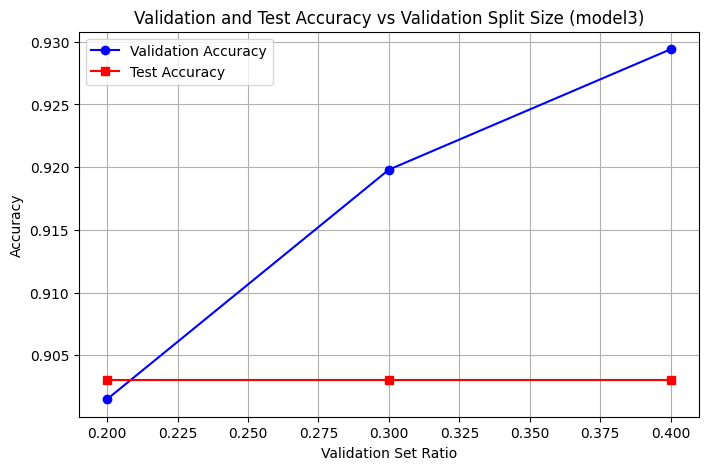

In [19]:
split_ratios = [0.2, 0.3, 0.4]  # Different validation set sizes to test
results = {'split_ratio': [], 'val_acc': [], 'test_acc': []}
RANDOM_STATE = 42

for ratio in split_ratios:
    print(f"\n{'='*50}\nTesting validation split: {ratio*100:.0f}%\n{'='*50}")

    # Split the original training data (flat/raw) — no retraining here!
    _, X_val_raw, _, y_val = train_test_split(
        X_train_flat, y_train, test_size=ratio, random_state=RANDOM_STATE, stratify=y_train
    )

    # Scale validation data with saved scaler
    X_val_scaled = scaler.transform(X_val_raw)

    # Apply PCA transform with saved PCA
    X_val_pca = pca_95.transform(X_val_scaled)

    # Evaluate model3 on validation set
    val_loss, val_acc = model3.evaluate(X_val_pca, y_val, verbose=0)
    print(f"Validation Accuracy: {val_acc:.4f}")

    # Evaluate model3 on test set (fixed test data)
    test_loss, test_acc = model3.evaluate(X_test_pca, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}")

    results['split_ratio'].append(ratio)
    results['val_acc'].append(val_acc)
    results['test_acc'].append(test_acc)

# Plot validation and test accuracy vs validation split size
plt.figure(figsize=(8, 5))
plt.plot(results['split_ratio'], results['val_acc'], 'bo-', label='Validation Accuracy')
plt.plot(results['split_ratio'], results['test_acc'], 'rs-', label='Test Accuracy')
plt.xlabel('Validation Set Ratio')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracy vs Validation Split Size (model3)')
plt.grid(True)
plt.legend()
plt.show()


# **UI TO PREDICT USER INPUT**

In [20]:
def preprocess_image(img):
    """Fixed version with proper standardization"""
    try:
        # Resize and convert
        img = img.resize((32, 32))
        img_array = np.array(img).astype('float32') / 255.0  # Normalize 0-1

        # Flatten and standardize
        img_flat = img_array.reshape(1, -1)
        img_scaled = scaler.transform(img_flat)  # Uses training's StandardScaler

        # PCA transform
        img_pca = pca_95.transform(img_scaled)

        return img_pca
    except Exception as e:
        print(f"Error: {str(e)}")
        return None

def predict_ann(img):
    img_pca = preprocess_image(img)
    if img_pca is None:
        return "Error"

    proba = model3.predict(img_pca, verbose=0)[0][0]
    # print(f"Debug - Raw probability: {proba:.4f}")  # Check prediction values

    # Adjust threshold if needed
    return 1 if proba > 0.5 else 0
def predict_knn(img):
    return 1  # Dummy output (vehicle)

def predict_svm(img):
    return 0  # Dummy output (animal)

# Title
title = widgets.HTML(value="<h2 style='color:#2c3e50;'>Image Classification App</h2>")

# Upload widget (will be reset after prediction)
upload = widgets.FileUpload(accept='image/*', multiple=False)
upload.layout.margin = '10px 0px 10px 0px'

# Model selector
model_selector = widgets.Dropdown(
    options=['ANN', 'KNN', 'SVM'],
    description='Select Model:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='60%')
)

# Predict button
predict_button = widgets.Button(description='Predict', button_style='success', layout=widgets.Layout(width='40%'))

# Result label
result_label = widgets.HTML(value="", layout=widgets.Layout(margin='10px 0px 10px 0px'))

# Output area
output = widgets.Output()

# Prediction function
def on_predict_clicked(b):
    global upload
    with output:
        clear_output()
        if upload.value:
            img_data = list(upload.value.values())[0]
            pil_img = Image.open(io.BytesIO(img_data['content'])).convert('RGB')

            # Show uploaded image
            plt.figure(figsize=(3, 3))
            plt.imshow(pil_img)
            plt.axis('off')
            plt.title("Uploaded Image")
            plt.show()

            # Predict
            selected_model = model_selector.value
            if selected_model == 'ANN':
                prediction = predict_ann(pil_img)
            elif selected_model == 'KNN':
                prediction = predict_knn(pil_img)
            elif selected_model == 'SVM':
                prediction = predict_svm(pil_img)

            label_text = "Prediction: <b style='color:green;'>Vehicle</b>" if prediction == 1 else "Prediction: <b style='color:blue;'>Animal</b>"
            result_label.value = label_text

            # Reset upload
            upload.close()
            upload = widgets.FileUpload(accept='image/*', multiple=False)
            upload.layout.margin = '10px 0px 10px 0px'
            input_widgets.children = (upload, model_selector, predict_button)

        else:
            result_label.value = "<span style='color:red;'>⚠ Please upload an image.</span>"

# Attach event
predict_button.on_click(on_predict_clicked)

# Layout grouping
input_widgets = widgets.VBox([upload, model_selector, predict_button])
card = widgets.VBox([
    title,
    input_widgets,
    result_label,
    output
], layout=widgets.Layout(
    padding='20px',
    border='2px solid #dcdcdc',
    border_radius='10px',
    background_color='#f9f9f9',
    width='50%'
))

display(card)